In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy
from scipy.interpolate import RegularGridInterpolator

import yaml
from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient.model import NeurOrient, NeurOrientLightning
from neurorient.utils_visualization import save_mrc, display_volumes, display_fsc, display_images
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.metrics import compute_fsc
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh
from neurorient.configurator    import Configurator

from sklearn.model_selection import train_test_split

import skopi as sk
import h5py
from pytorch3d.transforms import (
    matrix_to_quaternion, quaternion_to_matrix, so3_rotation_angle, so3_relative_angle,
    matrix_to_axis_angle
    )

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_phase(atom_pos, q_xyz):
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:90: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cal(f_hkl, atom_pos, q_xyz, xyz_ind, pixel_number):
/pscratch/sd/z

In [2]:
from neurorient.utils_config import prepare_dataset, flags_long2short

In [3]:
with open('/pscratch/sd/z/zhantao/neurorient_repo/experiments/experiments_fluctuation_pred.yaml') as f:
    experiments = yaml.safe_load(f)

In [4]:
pdb = '1BXR'
num_images = 10000
increase_factor = 100

In [5]:
flags = 'f1_p1_g1_b0_c0'
net_type = 'resnet18'
if increase_factor == 10:
    ckpt_path = experiments[pdb.lower()][net_type][flags]
else:
    ckpt_path = experiments[pdb.lower()][net_type][f'{increase_factor}x'][flags]
print('loading model from: ', ckpt_path)

loading model from:  /pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations_fluctuation_pred/lightning_logs/1bxr/version_17543349/checkpoints/1BXR-epoch=850-step=25510.ckpt


In [6]:
with open(os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), 'input.yaml'), 'r') as fh:
    config_dict = yaml.safe_load(fh)
CONFIG = Configurator.from_dict(config_dict)

In [7]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase1_poissonFalse_num{num_images//1000:d}K.pt')
model_dir = '/pscratch/sd/z/zhantao/neurorient_repo/model_archived'
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/spinifel_benchmark_data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [8]:
dataset = prepare_dataset(CONFIG, spi_data['intensities'])

transformation: photon fluctuation applied to training and validation datasets.
transformation: poisson noise applied to training and validation datasets.
transformation: gaussian noise applied to training and validation datasets.
3 transformations applied to training and validation datasets.


100%|██████████| 10000/10000 [00:40<00:00, 244.56it/s]


created dataset with 10000 images.


In [9]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=80)

In [10]:
model = NeurOrientLightning.load_from_checkpoint(ckpt_path)
model.eval();
model.to(model.dtype);

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [12]:
orientations_pred = []
slices_to_save = []
fluctuations = []
fluctuations_true = []
with torch.no_grad():
    for i_batch, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

        if isinstance(batch, dict):
            slices_true = batch['image'].to(model.dtype)
            input_mask  = batch['input_mask'].bool()
            general_mask = batch['general_mask'].bool()
            fluctuations_true.append(batch['photon_flux_factor'].cpu().numpy())
        else:
            slices_true = batch[0].to(model.dtype)
            input_mask = torch.ones_like(slices_true).bool().bool()
            general_mask = torch.ones_like(slices_true).bool().bool()
        
        
        slices_to_save.append((general_mask * slices_true).cpu().numpy())

        # Apply input and general masks and loss scale factor to get input slices.
        slices_input  = input_mask  * general_mask * torch.log(slices_true * model.model.loss_scale_factor + 1.)
        # Apply general mask and loss scale factor to get target slices.
        slices_output = general_mask * torch.log(slices_true * model.model.loss_scale_factor + 1.)

        # predict orientations from images
        orientations = matrix_to_quaternion(model.model.image_to_orientation(slices_input.to(device))).cpu()

        orientations_pred.append(orientations)
        fluctuations.append(model.model.fluctuation_predictor(slices_input.to(device)).detach().cpu())

orientations_pred = torch.cat(orientations_pred)
slices_to_save = np.vstack(slices_to_save)
fluctuations = torch.vstack(fluctuations).detach().cpu().numpy().squeeze()
fluctuations_true = np.vstack(fluctuations_true).squeeze()

100%|██████████| 125/125 [00:03<00:00, 37.54it/s]


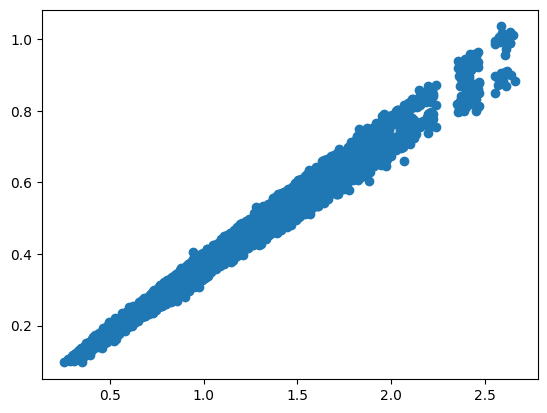

In [13]:
plt.plot(fluctuations_true, fluctuations, 'o')

In [14]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions

orientations_pred = []
slices_to_save = []
fluctuations = []
with torch.no_grad():
    for i_batch, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

        if isinstance(batch, dict):
            slices_true = batch['image'].to(model.dtype)
            input_mask  = batch['input_mask'].bool()
            general_mask = batch['general_mask'].bool()
        else:
            slices_true = batch[0].to(model.dtype)
            input_mask = torch.ones_like(slices_true).bool().bool()
            general_mask = torch.ones_like(slices_true).bool().bool()

        slices_to_save.append((general_mask * slices_true).cpu().numpy())

        # Apply input and general masks and loss scale factor to get input slices.
        slices_input  = input_mask  * general_mask * torch.log(slices_true * model.model.loss_scale_factor + 1.)
        # Apply general mask and loss scale factor to get target slices.
        slices_output = general_mask * torch.log(slices_true * model.model.loss_scale_factor + 1.)

        # predict orientations from images
        orientations = matrix_to_quaternion(model.model.image_to_orientation(slices_input.to(device))).cpu()

        orientations_pred.append(orientations)
        fluctuations.append(model.model.fluctuation_predictor(slices_input.to(device)).detach().cpu())

orientations_pred = torch.cat(orientations_pred)
slices_to_save = np.vstack(slices_to_save)
fluctuations = torch.vstack(fluctuations).detach().cpu().numpy()

100%|██████████| 125/125 [00:02<00:00, 52.19it/s]


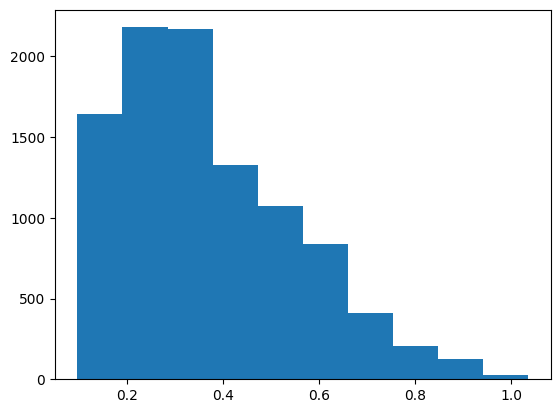

In [15]:
plt.hist(fluctuations.squeeze());

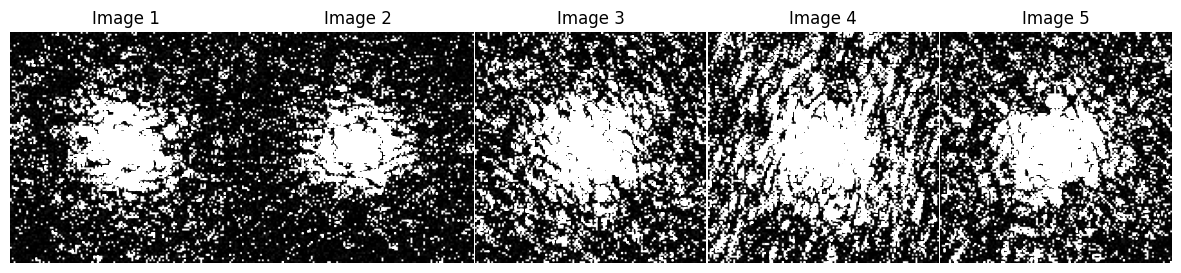

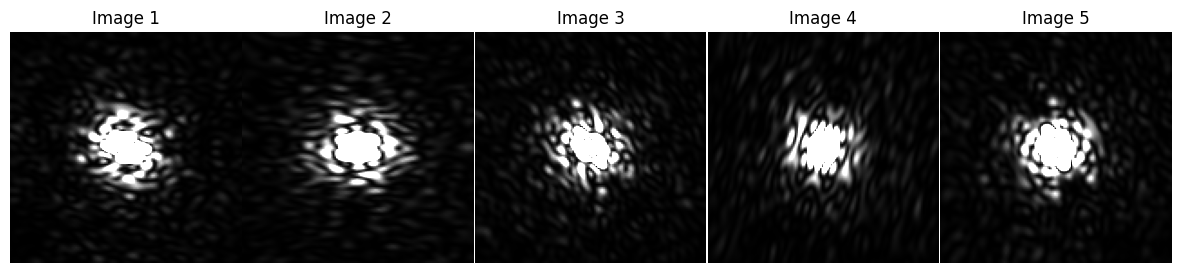

In [16]:
display_images(slices_to_save[:5,0], columns=5, vmax=1)
display_images(spi_data['intensities'][:5], columns=5, vmax=.1)

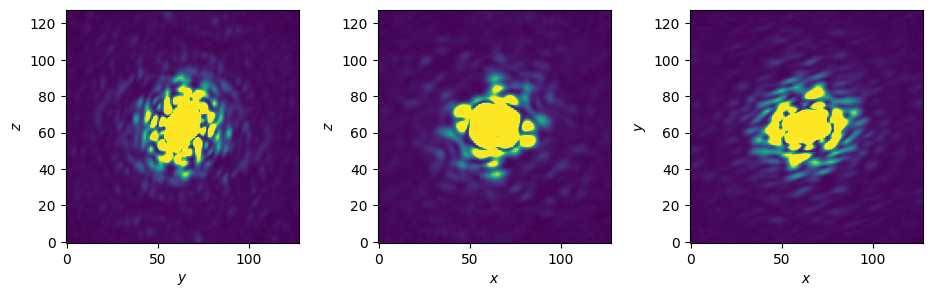

In [17]:
import numpy as np

grid_reciprocal = model.model.grid_position_reciprocal / model.model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.model.predict_intensity(np.pi * grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1) / model.model.loss_scale_factor

display_volumes(intensity_pred, closefig=False, vmax=intensity_pred.max()*0.001)

In [18]:
# phase_retriever = PhaseRetriever(n_phase_loops=100, beta_HIO=0.3, beta_DM=0.3, shrink_wrap_method='max')
# rho_phased, support_phased = phase_retriever.phase(intensity_pred.clip(intensity_pred.max() * 1e-5).sqrt().to(device))
# # rho_phased, support_phased = phase_retriever.phase(torch.from_numpy(intensity_pred - intensity_pred.min()).sqrt().to(device))
# display_volumes(rho_phased, closefig=False, vmin=0)

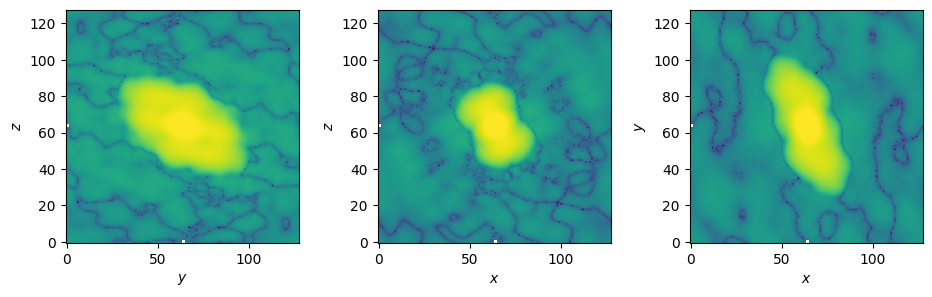

In [19]:
# intensities = torch.fft.fftshift(torch.fft.fftn(rho_phased)).abs().pow(2)
ac = torch.fft.ifftshift(torch.fft.ifftn(intensity_pred).abs()).detach().cpu()
display_volumes(ac.log(), vmax=0.01 * ac.log().max(), closefig=False)

In [23]:
slices_to_save_normed = slices_to_save / fluctuations[...,None,None]

In [21]:
h5_fpath = os.path.join(
    save_dir, 'fluctuation_pred',
    f'{pdb}_increase{increase_factor:d}_num{num_images//1000}K_{flags_long2short(flags)}.h5')
print(h5_fpath)

/pscratch/sd/z/zhantao/neurorient_repo/spinifel_benchmark_data/fluctuation_pred/1BXR_increase100_num10K_fpg.h5


In [22]:
with h5py.File(h5_fpath, 'w') as f:
    f.create_dataset('intensities', data=slices_to_save)
    f.create_dataset('intensities_normed', data=slices_to_save_normed)
    f.create_dataset('orientations', data=spi_data['orientations'].cpu().numpy())
    f.create_dataset('orientations_prior', data=orientations_pred.numpy())
    f.create_dataset('ac', data=ac.numpy())
    f.create_dataset('grid_position_real', data=model.model.grid_position_real.cpu().numpy())
    f.create_dataset('pixel_position_reciprocal', data=spi_data['pixel_position_reciprocal'].numpy())
    f.create_dataset('pixel_distance_reciprocal', data=spi_data['pixel_position_reciprocal'].norm(dim=-1).numpy())
    f.create_dataset('pixel_index_map', data=spi_data['pixel_index_map'].numpy())
print("data wrote to: \n", h5_fpath)

data wrote to: 
 /pscratch/sd/z/zhantao/neurorient_repo/spinifel_benchmark_data/fluctuation_pred/1BXR_increase100_num10K_fpg.h5
